# Introduction

In [1]:
import string
import pandas as pd
import numpy as np
import datetime 
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from wordcloud import WordCloud
import seaborn as sns

In [2]:
#import the stock price data
SP_df = pd.read_csv("WIKI_PRICES.csv")

In [3]:
SP_df.head()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
0,A,1999-11-18,45.50,50.00,40.00,44.00,44739900.0,0.0,1.0,31.105117,34.181447,27.345157,30.079673,44739900.0
1,A,1999-11-19,42.94,43.00,39.81,40.38,10897100.0,0.0,1.0,29.355027,29.396044,27.215268,27.604936,10897100.0
2,A,1999-11-22,41.31,44.00,40.06,44.00,4705200.0,0.0,1.0,28.240711,30.079673,27.386175,30.079673,4705200.0
3,A,1999-11-23,42.50,43.63,40.25,40.25,4274400.0,0.0,1.0,29.054230,29.826730,27.516065,27.516065,4274400.0
4,A,1999-11-24,40.13,41.94,40.00,41.06,3464400.0,0.0,1.0,27.434029,28.671398,27.345157,28.069804,3464400.0


In [4]:
#check the number of data
len(SP_df)

14935063

In [5]:
#import the news data
NEWS_df = pd.read_csv("uci-news-aggregator.csv")

In [6]:
NEWS_df = NEWS_df[NEWS_df['CATEGORY']=='b']
NEWS_df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [7]:
#check the number of data
len(NEWS_df)

115967

In [8]:
new_ticker1_df = pd.read_csv("companylist.csv")
new_ticker2_df = pd.read_csv("companylistNYSE.csv")
new_ticker_df = pd.concat([new_ticker1_df, new_ticker2_df])

In [9]:
new_ticker_df.head()

,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,PIH,"1347 Property Insurance Holdings, Inc.",7.825,4.661169e+07,n/a,2014,Finance,Property-Casualty Insurers,http://www.nasdaq.com/symbol/pih,NaN
1,TURN,180 Degree Capital Corp.,1.6,4.979450e+07,n/a,n/a,Finance,Finance/Investors Services,http://www.nasdaq.com/symbol/turn,NaN
2,FLWS,"1-800 FLOWERS.COM, Inc.",9.65,6.304837e+08,n/a,1999,Consumer Services,Other Specialty Stores,http://www.nasdaq.com/symbol/flws,NaN
3,FCCY,1st Constitution Bancorp (NJ),17.25,1.384716e+08,n/a,n/a,Finance,Savings Institutions,http://www.nasdaq.com/symbol/fccy,NaN
4,SRCE,1st Source Corporation,48.67,1.261704e+09,n/a,n/a,Finance,Major Banks,http://www.nasdaq.com/symbol/srce,NaN


In [10]:
# create a dictionary which includes the companis' name and ticker
companies = {}
for ind, row in new_ticker_df.iterrows():
    if (len(row['Name']) > 1) & (len(row['Symbol']) > 1): 
        companies[row['Name']] = row['Symbol']

In [11]:
# 

remove_list = ['inc', 'plc', 'ltd', 'corporation', 'corp', 'incorporated', 'limited']
translator = str.maketrans('', '', string.punctuation)
filtered_companies = {}
for name, ticker in companies.items():
    lowercase_name = name.lower()
    lowercase_name = lowercase_name.translate(translator)
    for word in remove_list:
        lowercase_name = lowercase_name.replace(word, "")
        
    lowercase_name = lowercase_name.rstrip()
    filtered_companies[lowercase_name] = ticker

In [12]:
#try to check whether there is enough data for above companies

# def count_news(companies):
#     total = 0
#     news_count = {}
#     for key, item in companies.items():
#         num =  len(NEWS_df[NEWS_df['TITLE'].str.contains(key, na=False)])
#         total += num
#         news_count[key] = num
    
#     return total, news_count

# total, news_count = count_news(companies)
# print(total)
# print(news_count)

In [13]:
#try to check whether there is corresponding stock price data for above companies

# for key, item in companies.items():
#     if item in SP_df['ticker'].values:
#         continue
#     else:
#         print('Following company doesn\'nt exist: {}'.format(item))

In [14]:
#delete the companies with the small number of news in NEWS_df

# for key, item in news_count.items():
#     if news_count[key] < 100:
#         companies.pop(key)

# total_v2, news_count_v2 = count_news(companies)
# print(total_v2)
# print(news_count_v2)

In [15]:
#drop the unnecessary column of NEWS_df

# NEWS_df = NEWS_df.drop(["STORY","HOSTNAME"], axis=1)
# NEWS_df.columns

In [16]:
#convert timestamp to date
NEWS_df['TIMESTAMP'] = pd.to_datetime(NEWS_df['TIMESTAMP'], unit='ms')

In [17]:
#Create a function that determine whether the news title includes any company

def company_in_news(paragraph, companies):
    """
    input; paragraph: string, companies: dictionary
    output; boolean
    """
    #words = paragraph.split()
    is_inNews = False
    for name, ticker in companies.items():
        if ' ' + name + ' ' in paragraph or ' ' + ticker + ' ' in paragraph:
            return ticker
    
    return np.nan

In [18]:
# create a new column that have a ticker corresponding each news
NEWS_df['ticker'] = NEWS_df['TITLE'].apply(company_in_news, args=(filtered_companies,))
NEWS_companies_df = NEWS_df.dropna(how='any')

In [19]:
NEWS_df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,ticker
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,2014-03-10 16:52:50.698,NaN
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,2014-03-10 16:52:51.207,NaN
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,2014-03-10 16:52:51.550,NaN
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,2014-03-10 16:52:51.793,NaN
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,2014-03-10 16:52:52.027,NaN


memo for myself  
__number difference with str.contain()__  
len(NEWS_companies_df)

In [20]:
#create the new dataframe which consists of relevant news only

# NEWS_companies_df = NEWS_df[NEWS_df['TITLE'].apply(company_in_news, args=(filtered_companies,)) == True]

In [21]:
#create a function which give the label of the company's ticker to the news

# def label_news(paragraph, companies):
#     """
#     input; paragraph: string, companies: dictionary
#     output; name: company's ticker
#     """
#     words = paragraph.split()
#     for i in range(len(words)):
#         if words[i] in companies.keys():
#             return companies[words[i]]
    
#     return 'NaN'



In [22]:
#remove company's name in news title

def remove_names(paragraph, companies):
    """
    input; paragraph: string, companies: dictionary
    output; name: company's ticker
    """
    words = paragraph.split()
    for i in range(len(words)):
        if words[i] in companies.keys() or words[i] in companies.items():
            return paragraph.replace(words[i], "")
    
    return paragraph

#NEWS_companies_df['TITLE'] = NEWS_companies_df['TITLE'].apply(remove_names, args=(filtered_companies,))

memo for myself  
__could be together with company_in_news__  
__got a warning__

In [23]:
# create a list that store the dates in order
date_set = set(SP_df['date'])
date_list = list(date_set)
date_list.sort()

# create a list that gives the adj_close corresponding date and ticker
combi = {}
for date, ticker, close in zip(SP_df['date'], SP_df['ticker'], SP_df['adj_close']):
    combi[(date, ticker)] = close

In [24]:
#create a function that takes the corresponding the stock price move
#this function runs very slow. next cell might take more than 10 mins to run
def get_move(row):
    
    """
    input; row: entire row, SP_df: DataFrame of stock price
    output; boolean
    """    
    
    date_tmp = row['TIMESTAMP']
    
    #check the hour of the news, and then if it's after 17, make the date next day.
    if date_tmp.hour >= 17:
        date = date_tmp + datetime.timedelta(days=1)
    else:
        date = date_tmp
    date1 = datetime.datetime.strftime(date, "%Y-%m-%d")

    
    #get the date0
    try:
        ind = date_list.index(date1)
    except ValueError:
        return np.nan
    date0 = date_list[ind-1]
    

#     day0_price = SP_df.loc[(SP_df['date'] == date0) & (SP_df['ticker'] == row['ticker']), 'adj_close']
#     day1_price = SP_df.loc[(SP_df['date'] == date1) & (SP_df['ticker'] == row['ticker']), 'adj_close']

    try:
        day0_price = combi[(date0, row['ticker'])]
        day1_price = combi[(date1, row['ticker'])]
    except KeyError:
        return np.nan
    
    #return True if the stock price went up by more than 10%
    if ((day1_price - day0_price)/day0_price) > 0.000:
        return True
    elif ((day1_price - day0_price)/day0_price) <= 0.000:
        return False
    else:
        return np.nan
    


In [25]:
NEWS_companies_df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,ticker
9,10,ECB unlikely to end sterilisation of SMP purch...,http://www.iii.co.uk/news-opinion/reuters/news...,Interactive Investor,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.iii.co.uk,2014-03-10 16:55:01.265,SMP
10,11,ECB unlikely to end sterilization of SMP purch...,http://in.reuters.com/article/2014/03/10/us-ec...,Reuters India,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,2014-03-10 16:55:01.410,SMP
22,23,Bad loan triggers key feature in ECB bank test...,http://www.globalpost.com/dispatch/news/thomso...,GlobalPost,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.globalpost.com,2014-03-10 16:55:03.726,KEY^I
29,30,REFILE-Bad loan triggers key feature in ECB ba...,http://in.reuters.com/article/2014/03/10/euroz...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,2014-03-10 16:55:05.070,KEY^I
61,62,EBay Asks Shareholders To Vote Against PayPal ...,http://techcrunch.com/2014/03/10/ebay-asks-sha...,TechCrunch,b,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,techcrunch.com,2014-03-10 17:02:02.918,CEO


In [26]:
NEWS_companies_df['IsUp'] = NEWS_companies_df.apply(get_move, axis = 1)

C:\Users\the_b\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
print(NEWS_companies_df['TITLE'][165868])
[k for (k, v) in companies.items() if v == 'TGT']

New EU sanctions target Russia army, intelligence chiefs


['Target Corporation']

In [28]:
NEWS_companies_df.sample(10)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,ticker,IsUp
25347,25348,Mulberry CEO says see you later as profits dro...,http://www.europeanceo.com/business-and-manage...,EuropeanCEO,b,dWViVu-FlsfOc9MRK17sx7ZRB1lWM,www.europeanceo.com,2014-03-20 13:30:32.790,CEO,NaN
173075,173411,"Is This the Best Space Stock? ORB, ATK, ASTC &...",http://www.smallcapnetwork.com/Is-This-the-Bes...,SmallCap Network,b,dH-RkrrR6W7iUCMGiLkxn-FrmMvgM,www.smallcapnetwork.com,2014-04-30 13:31:20.068,ASTC,NaN
222986,223432,"Target fired CEO Gregg Steinhafel, cut compens...",http://www.startribune.com/business/259794771....,Minneapolis Star Tribune,b,dSOW6z2-3uE0lUMMrPoardiyY-ktM,www.startribune.com,2014-05-20 09:25:38.788,CEO,NaN
338606,339066,Forex - Japanese yen holds steady after Tankan...,http://www.investing.com/news/forex-news/forex...,Investing.com,b,dZdgzuFO1Td5IiMTZwgLfLV2KNHRM,www.investing.com,2014-07-01 12:56:17.256,KEY^I,NaN
334480,334940,"Money in the Bank, Rob Van Dam & Latest WWE Ne...",http://bleacherreport.com/articles/2112219-mon...,Bleacher Report,b,dZUy5eJ7UG3BZEMQTo0u9JAvNwbnM,bleacherreport.com,2014-06-30 17:46:50.403,WWE,False
359465,359925,Libya: PM announces takeover of two oil ports,http://www.africanmanager.com/site_eng/detail_...,African Manager,b,dmVGLh9qgVvSeAMQAv4tjFts0w6HM,www.africanmanager.com,2014-07-05 17:52:55.505,PM,NaN
141041,141377,PepsiCo profit rises 13% giving CEO respite fr...,http://www.livemint.com/Companies/1lg7siXgdG0O...,Livemint,b,dCVLzzm4CssAm3Mq5Eyb2V1IcndwM,www.livemint.com,2014-04-20 13:20:06.473,CEO,NaN
176045,176381,Target Chairman & CEO Out In Wake Of Data Breach,http://minnesota.cbslocal.com/2014/05/05/targe...,CBS Local,b,dpyfzwtPWIiWllMXoMerDydpmTaVM,minnesota.cbslocal.com,2014-05-05 15:44:20.126,CEO,NaN
60269,60270,Morgan Stanley CEO awarded $12 mln for 2013 -a...,http://in.reuters.com/article/2014/03/28/morga...,Reuters,b,dEQYFo54_hjUMLMd_1nHnqgLJ9GXM,in.reuters.com,2014-03-29 04:29:59.891,CEO,NaN
330436,330896,Former CEO of Procter & Gamble named head of V...,http://wgntv.com/2014/06/29/former-ceo-of-proc...,WGNtv.com,b,dh_pGB0zaOte3cMswaGIu15zcEVHM,wgntv.com,2014-06-29 21:53:34.233,CEO,NaN


In [29]:
NEWS_companies_df['TITLE'] = NEWS_companies_df['TITLE'].apply(remove_names, args=(filtered_companies,))
with_move_df = NEWS_companies_df.dropna(how='any')

C:\Users\the_b\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
# def get_sentiment(sentences):
#     blob = TextBlob(sentences)
#     for sentence in blob.sentences:
#         return sentence.sentiment.polarity

In [31]:
# with_move_df['Sentiment'] = with_move_df['TITLE'].apply(get_sentiment)

In [32]:
# check the number of True and False
unique, counts = np.unique(with_move_df['IsUp'].values, return_counts=True)
dict(zip(unique, counts))

{False: 842, True: 731}

In [33]:
# truncate the time in the day
def add_time(row):
    return datetime.datetime.strftime(row['TIMESTAMP'], "%Y-%m-%d")

In [34]:
with_move_df['Day'] = with_move_df.apply(add_time, axis = 1)


C:\Users\the_b\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
grouped = with_move_df.groupby(['Day','ticker'])
with_move_df.sample(10)


,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,ticker,IsUp,Day
180690,181026,Apple welcomes new Senior VP Angela Ahrendts w...,http://9to5mac.com/2014/05/05/apple-welcomes-n...,9 to 5 Mac,b,dSUesVoEgjcnpeMktVnPs5SJpUdrM,9to5mac.com,2014-05-06 10:41:16.673,AAPL,False,2014-05-06
364011,364471,Forex - EUR/USD. GBP/USD Flows: ADM to buy WIL...,http://www.fxmarketalerts.com/free/document.as...,FXMarketAlerts.com,b,dZEoQtgqqTc0zGMzU5yDMgvoX_WkM,www.fxmarketalerts.com,2014-07-07 17:24:31.188,ADM,False,2014-07-07
17091,17092,No evidence linking Chinese aboard missing je...,http://www.660news.com/2014/03/18/no-evidence-...,660 News,b,dZqPur_Xtkpjv-M0bIhrbG4A_ZC0M,www.660news.com,2014-03-18 16:10:15.224,CIA,True,2014-03-18
184070,184406,Walt Disney Records to Release 'Legacy' Editio...,http://www.broadwayworld.com/bwwmovies/article...,Broadway World,b,dEznTp4zoY6kvXMiDQBsZ6XZvJxYM,www.broadwayworld.com,2014-05-07 02:46:35.543,LION,True,2014-05-07
12539,12540,Alibaba starts rolling for IPO in the US,http://www.businesstimes.com.sg/premium/china/...,Business Times \(subscription\),b,dOOSaC3dQLzj6BMGq5Tso8w3ywZgM,www.businesstimes.com.sg,2014-03-17 11:06:35.060,BLL,True,2014-03-17
229719,230165,Some MPC members 'nearer rate rise',http://www.shropshirestar.com/shropshire-busin...,shropshirestar.com,b,duVJvN92-QU5KFMWv3_ThxbESOoSM,www.shropshirestar.com,2014-05-21 13:48:52.640,MPC,False,2014-05-21
322195,322655,On topic: Tech to know now,http://www.siliconbeat.com/2014/06/26/on-topic...,SiliconBeat,b,dtzEtCIuptnGnYM-d1hm66m1CLiQM,www.siliconbeat.com,2014-06-27 07:37:29.155,NWSA,False,2014-06-27
46841,46842,Coast Guard: BP let 9 to 18 barrels of oil in ...,http://www.journalgazette.net/article/20140326...,Fort Wayne Journal Gazette,b,dhed2msTQe-xMwMLU9Jdk8W2RbyuM,www.journalgazette.net,2014-03-27 00:00:53.566,BP,True,2014-03-27
288172,288632,"Mergers, technology boost stocks",http://gazette.com/mergers-technology-news-boo...,Colorado Springs Gazette,b,dnGJHdL1CN5lRTMLK6PRlSAZsSRLM,gazette.com,2014-06-15 20:15:03.790,NWSA,False,2014-06-15
290196,290656,Poroshenko calls for Ukraine truce to buy for...,http://www.theglobeandmail.com/news/world/poro...,The Globe and Mail,b,ddj5NjVPliMvgHMxoJt8jgDPRCu4M,www.theglobeandmail.com,2014-06-16 14:13:17.532,TIME,True,2014-06-16


In [36]:
print(with_move_df['TITLE'][170707])
print(with_move_df['TITLE'][47720])

KeyError: 170707

In [37]:
# create functions that give the aggregated title and Isup
def concat(series):
    all_titles = ''
    for title in series:
            all_titles += '' + title
    return all_titles

def concat2(series):
    return series.sample(1)

#grouped.agg({'TITLE': concat})
#grouped.agg({'IsUp': concat2})

In [38]:
def take_important(df, IsTrue):
    new_df = df['TITLE'][df['IsUp']==IsTrue]
    #print(type(new_df))
    counter = Counter()
    for index, row in new_df.iteritems():
        counter += Counter(row.split())

    #counter = Counter(df['TITLE'][df['IsUp']==IsTrue])
        
#     for index, row in df.iterrows():
#         if row['IsUp'] == IsTrue:
#             for w in row['TITLE'].split():
#                 if w in count:
#                     count[w] += 1
#                 else:
#                     count[w] = 1
    
    return counter

In [39]:
count_up = take_important(with_move_df, True)
#count_up.most_common(50)

In [40]:
count_down = take_important(with_move_df, False)
#count_down.most_common(50)

In [41]:
count_vectorizer = CountVectorizer()
X = count_vectorizer.fit_transform(grouped.agg({'TITLE': concat}).TITLE)
y = grouped.agg({'IsUp': concat2})
y = y.IsUp.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(len(y))
#clf = LinearSVC()

parameters = {'C':[1, 10, 100, 1000]}
svr = LinearSVC(random_state=0)
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(confusion_matrix(y_test, predicted))
print(classification_report(y_test,
                            predicted,
                            target_names=['up', 'down']))
print(classification_report(y_train,
                            clf.predict(X_train),
                            target_names=['up', 'down']))
print(accuracy_score(y_test, predicted))

582
[[28 29]
 [39 21]]
             precision    recall  f1-score   support

         up       0.42      0.49      0.45        57
       down       0.42      0.35      0.38        60

avg / total       0.42      0.42      0.42       117

             precision    recall  f1-score   support

         up       1.00      1.00      1.00       217
       down       1.00      1.00      1.00       248

avg / total       1.00      1.00      1.00       465

0.418803418803


In [42]:
clf.best_params_

{'C': 10}

In [43]:
for word, coef in zip(count_vectorizer.get_feature_names(), clf.best_estimator_.coef_[0]):
    if coef >= 0.7:
        print('positive coef {1:04f}: {0}'.format(word,coef))

print("")
        
for word, coef in zip(count_vectorizer.get_feature_names(), clf.best_estimator_.coef_[0]):
    if coef <= -1:
        print('negative coef {1:04f}: {0}'.format(word,coef))

In [44]:
parameters = {'C':[1, 10, 100, 1000]}
LR = LogisticRegression()
clf2 = GridSearchCV(LR, parameters)
clf2.fit(X_train, y_train)
predicted2 = clf2.predict(X_test)
print(confusion_matrix(y_test, predicted2))
print(classification_report(y_test,
                            predicted2,
                            target_names=['up', 'down']))
print(classification_report(y_train,
                            clf2.predict(X_train),
                            target_names=['up', 'down']))
print(accuracy_score(y_test, predicted2))

[[28 29]
 [35 25]]
             precision    recall  f1-score   support

         up       0.44      0.49      0.47        57
       down       0.46      0.42      0.44        60

avg / total       0.45      0.45      0.45       117

             precision    recall  f1-score   support

         up       1.00      1.00      1.00       217
       down       1.00      1.00      1.00       248

avg / total       1.00      1.00      1.00       465

0.452991452991


In [45]:
clf2.best_params_

{'C': 10}

In [46]:
positive = ''
negative = ''
for word, coef in zip(count_vectorizer.get_feature_names(), clf.best_estimator_.coef_[0]):
    
    if coef >= 0:
        for i in range(round(float('{0:02f}'.format(coef*100)))):
            positive += ' ' + '{0}'.format(word)
    else:
        for i in range(-round(float('{0:02f}'.format(coef*100)))):
            negative += ' ' + '{0}'.format(word)



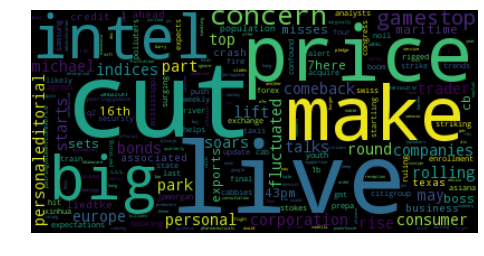

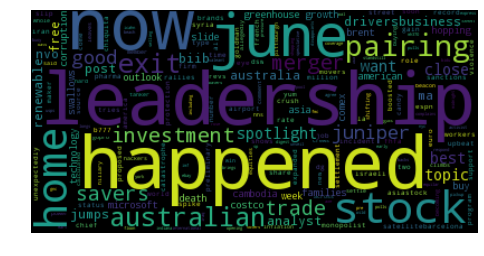

In [47]:
wordcloud = WordCloud(collocations=False).generate(positive)
wordcloud2 = WordCloud(collocations=False).generate(negative)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
# wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()

look into the news which includes strange words, such as soya  
use seaborn to visialize the data

In [62]:
NEWS_df[NEWS_df['TITLE'].str.contains('surgesus', na=False)]

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,ticker


In [63]:
with open('stopwords.txt') as f:
    stop_words = []
    for line in f:
        stop_words.append(line.rstrip())

In [64]:
def eliminate_stop_words(counter):
    dummy = counter.copy()
    punc = set(string.punctuation)
    punc.update(['...', '–'])
    for key, num in dummy.items():
        if key.lower() in stop_words or key in punc:
            counter.pop(key)
    
    return counter

In [65]:
count_up = eliminate_stop_words(count_up)
count_down = eliminate_stop_words(count_down)

In [66]:
def create_freq_table(counter, num):
    """
    counter: counter object
    num: int, which specify how many most common words it is needed to return
    return: DataFrame
    """
    counter2 = counter.most_common(num)
    counter2 = sorted(counter2, key=lambda tup: tup[1], reverse=True)
    
    words_freqs_up = {'words': [tup[0] for tup in counter2],
                      'freqs': [tup[1] for tup in counter2]}
    words_freqs_df = pd.DataFrame(words_freqs_up)
    
    return words_freqs_df

In [67]:
words_freqs_up_df = create_freq_table(count_up, 10)
words_freqs_down_df = create_freq_table(count_down, 10)

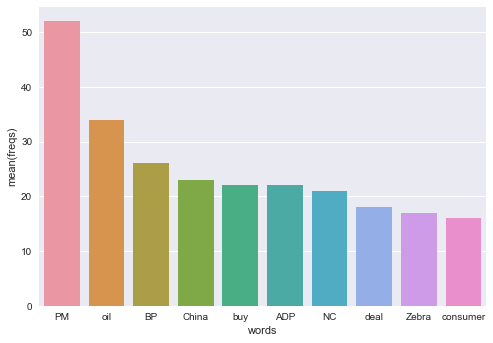

In [68]:
my_plot = sns.barplot(x='words', y='freqs', data=words_freqs_up_df)
my_plot.get_figure().savefig('freq_up.png', dpi=200)
sns.plt.show()

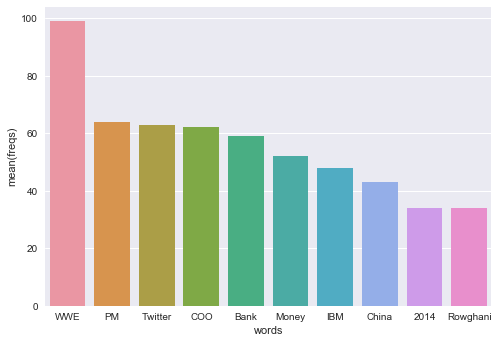

In [55]:
my_plot2 = sns.barplot(x='words', y='freqs', data=words_freqs_down_df)
my_plot2.get_figure().savefig('freq_down.png', dpi=200)
sns.plt.show()

In [56]:
words_freqs_up_df = create_freq_table(count_up, 20)
words_freqs_down_df = create_freq_table(count_down, 100)

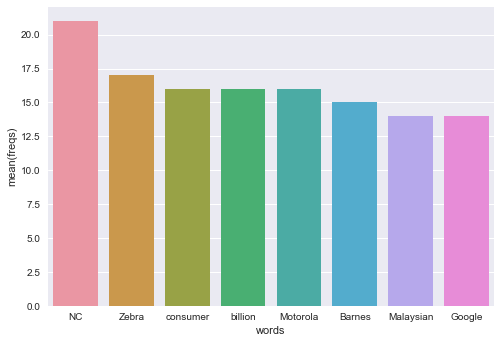

In [57]:
down_set = set(words_freqs_down_df.words)
words_freqs_up_df = words_freqs_up_df[words_freqs_up_df.apply(lambda row: row['words'] not in down_set, axis=1)]
my_plot = sns.barplot(x='words', y='freqs', data=words_freqs_up_df)
my_plot.get_figure().savefig('freq_up.png', dpi=200)
sns.plt.show()

In [58]:
words_freqs_up_df = create_freq_table(count_up, 100)
words_freqs_down_df = create_freq_table(count_down, 20)

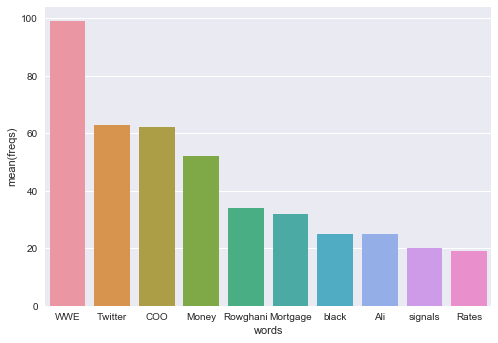

In [59]:
up_set = set(words_freqs_up_df.words)
words_freqs_down_df = words_freqs_down_df[words_freqs_down_df.apply(lambda row: row['words'] not in up_set, axis=1)]
my_plot = sns.barplot(x='words', y='freqs', data=words_freqs_down_df)
my_plot.get_figure().savefig('freq_up.png', dpi=200)
sns.plt.show()

In [60]:
NEWS_df[NEWS_df['TITLE'].str.contains('WWE', na=False)]

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,ticker
212740,213186,WWE investors call for Vince McMahon's head on...,http://www.cagesideseats.com/wwe/2014/5/17/572...,Cageside Seats \(blog\),b,dQ4Thx_EFXNgPHMYd8x6fhgp40PWM,www.cagesideseats.com,2014-05-18 02:52:10.531,NaN
212741,213187,WWE to address stockholders on Monday morning,http://fansided.com/2014/05/17/wwe-address-sto...,FanSided,b,dQ4Thx_EFXNgPHMYd8x6fhgp40PWM,fansided.com,2014-05-18 02:52:10.795,NaN
212743,213189,WWE stock plunges; Vince McMahon loses $357 mi...,http://www.sportingnews.com/soccer/story/2014-...,SportingNews.com,b,dQ4Thx_EFXNgPHMYd8x6fhgp40PWM,www.sportingnews.com,2014-05-18 02:52:11.352,NaN
212744,213190,WWE Owner McMahon Falls Out of the Billionaire...,http://www.newsmax.com/US/wwe-subscription-vin...,Newsmax.com,b,dQ4Thx_EFXNgPHMYd8x6fhgp40PWM,www.newsmax.com,2014-05-18 02:52:11.637,NaN
212745,213191,WWE Network News: Vince McMahon Net Worth Shri...,http://www.latinpost.com/articles/12830/201405...,Latin Post,b,dQ4Thx_EFXNgPHMYd8x6fhgp40PWM,www.latinpost.com,2014-05-18 02:52:12.015,CEO
212746,213192,WWE CEO Vince McMahon no longer a billionaire ...,http://www.sportskeeda.com/wwe/wwe-ceo-vince-m...,Sportskeeda \(blog\),b,dQ4Thx_EFXNgPHMYd8x6fhgp40PWM,www.sportskeeda.com,2014-05-18 02:52:12.298,CEO
212747,213193,WWE shares dive on investor disappointment,http://www.krdo.com/news/economy-tracker/WWE-s...,KRDO,b,dQ4Thx_EFXNgPHMYd8x6fhgp40PWM,www.krdo.com,2014-05-18 02:52:12.605,NaN
212748,213194,// Backstage Reaction to WWE Stock Drop,http://www.411mania.com/wrestling/news/323029,411mania.com,b,dQ4Thx_EFXNgPHMYd8x6fhgp40PWM,www.411mania.com,2014-05-18 02:52:12.858,WWE
212749,213195,Who Is To Blame For The WWE's Stock Price Woes?,http://www.411mania.com/wrestling/columns/3230...,411mania.com,b,dQ4Thx_EFXNgPHMYd8x6fhgp40PWM,www.411mania.com,2014-05-18 02:52:13.092,NaN
212752,213198,WWE Stock Takes A Huge Bodyslam,http://www.rantsports.com/pro-wrestling/2014/0...,Rant Sports,b,dQ4Thx_EFXNgPHMYd8x6fhgp40PWM,www.rantsports.com,2014-05-18 02:52:13.872,NaN
